In [3]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Note: As of 7/18/21 the results for all models are visible for beta = 3.2

In [4]:
from utils_model_sampling import sample_models_across_time

In [5]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [6]:
# Is it possible that it has memory issues?

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order()) # Should you run things locally?

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_0.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_3.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_3.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_1.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Adul

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_BERT_without_tags,_,_+-20_utts_context/run_models_across_time_1.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_0.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_2.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_3.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/age/young/CHILDES_BERT_with_tags,_younger_children,_same_utt_only/run_models_across_time_1.0.csv
/home/nwong/chompsky/childes/child_l

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Flat_prior_without_tags,_,_same_utt_only/run_models_across_time_4.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/Flat_prior_without_tags,_,_same_utt_only/run_models_across_time_1.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_unigram_without_tags,_,_same_utt_only/run_models_across_time_0.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_unigram_without_tags,_,_same_utt_only/run_models_across_time_3.5.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_default/all/all/CHILDES_unigram_without_tags,_,_same_utt_only/run_models_across_time_2.0.csv
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/scores_defau

In [7]:
raw_scores_across_time['model'].shape

(248116,)

In [137]:
set(raw_scores_across_time['model'])

{'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , +-20 utts context',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

In [139]:
# From the original analysis
original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram',
}

# Remove the all/all/20/with_tags! It's not updated.
set_of_models_that_works = {'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

is_filter = False #True
if is_filter:
    # I think if you don't copy R will get the slice and still try to compute over all models
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(original_set_of_models)].copy()
else:
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(set_of_models_that_works)]

In [140]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [141]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT with tags, , +-20 utts context",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT with tags, , same utt only",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT with tags, , +-20 utts context" = "BERT+Context+Tags",
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT with tags, , same utt only" = "BERT+OneUtt+Tags",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [142]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

                      model prior_surprisal
1               CDL+Context        3.405310
2           CDL+OneUtt+Tags        4.990529
3                CDL+OneUtt        5.032847
4              BERT+Context        4.728340
5               BERT+OneUtt        7.176585
6    CDL+Older+Context+Tags        3.998077
7         CDL+Older+Context        4.093210
8          CDL+Older+OneUtt        4.531644
9     CDL+Older+OneUtt+Tags        4.405459
10 CDL+Younger+Context+Tags        4.717997
11      CDL+Younger+Context        4.748473
12  CDL+Younger+OneUtt+Tags        5.416165
13       CDL+Younger+OneUtt        5.457277
14            CHILDES 1gram        8.772759
15             UniformPrior       12.948367


In [143]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id CDL+Context CDL+OneUtt+Tags   CDL+OneUtt BERT+Context
1           170 0.013552074    7.471361e-04 3.438002e-04 0.0003539034
2           743 0.926143706    5.038554e-05 4.461595e-05 0.0002658662
3          1303         NaN             NaN          NaN          NaN
4          1371          NA              NA           NA           NA
5          1529 0.001282274    6.939270e-03 7.239137e-03 0.0002260151
6          2875          NA              NA           NA           NA
   BERT+OneUtt CDL+Older+Context+Tags CDL+Older+Context CDL+Older+OneUtt
1 3.337238e-06                     NA                NA               NA
2 1.553577e-06                     NA                NA               NA
3          NaN                     NA                NA               NA
4           NA                     NA                NA               NA
5 2.206537e-04                     NA                NA               NA
6           NA                     NA                NA               NA

In [144]:
%%R
model_names = unique(successes_across_time$model)
print(model_names) # Probably because it's not a copy?

# It's still 18 levels -- why?

 [1] BERT+OneUtt              BERT+Context             CDL+OneUtt+Tags         
 [4] CDL+OneUtt               CDL+Context              CDL+Younger+OneUtt+Tags 
 [7] CDL+Younger+Context+Tags CDL+Younger+OneUtt       CDL+Younger+Context     
[10] CDL+Older+OneUtt+Tags    CDL+Older+Context+Tags   CDL+Older+OneUtt        
[13] CDL+Older+Context        UniformPrior             CHILDES 1gram           
18 Levels: CDL+Context+Tags CDL+Context CDL+OneUtt+Tags ... UniformPrior


In [145]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in t.test.default(successes_across_time_wide[[model_name]], successes_across_time_wide[[comparison_model_name]],  : 
  not enough 'x' observations

R[write to console]: In addition: 
R[write to console]: There were 18 warnings (use warnings() to see them)
R[write to console]: 




Error in t.test.default(successes_across_time_wide[[model_name]], successes_across_time_wide[[comparison_model_name]],  : 
  not enough 'x' observations


### Posterior Surprisal Across Ages

## Note to self: Check correctness of young/old divide len stdev here -- possibly ask about this; Is probably adaptive?

In [146]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

   age                    model posterior_surprisal_mean
1  0.5             BERT+Context                2.3319585
2  0.5              BERT+OneUtt                5.1606131
3  0.5              CDL+Context                1.1683321
4  0.5               CDL+OneUtt                3.0878637
5  0.5          CDL+OneUtt+Tags                2.8659071
6  0.5      CDL+Younger+Context                2.3415488
7  0.5 CDL+Younger+Context+Tags                2.2286598
8  0.5       CDL+Younger+OneUtt                3.0493889
9  0.5  CDL+Younger+OneUtt+Tags                2.9211120
10 0.5            CHILDES 1gram                3.6709663
11 0.5             UniformPrior                4.4973854
12 1.5             BERT+Context                1.7861651
13 1.5              BERT+OneUtt                3.1085596
14 1.5              CDL+Context                1.0836031
15 1.5               CDL+OneUtt                2.1118083
16 1.5          CDL+OneUtt+Tags                2.1099716
17 1.5      CDL+Younger+Context

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,BERT+Context,2.331958,0.396710
2,0.5,BERT+OneUtt,5.160613,0.687717
3,0.5,CDL+Context,1.168332,0.259956
4,0.5,CDL+OneUtt,3.087864,0.500955
5,0.5,CDL+OneUtt+Tags,2.865907,0.467373
...,...,...,...,...
88,4.0,CDL+Older+OneUtt+Tags,0.798944,0.082150
89,4.0,CDL+OneUtt,0.799944,0.079552
90,4.0,CDL+OneUtt+Tags,0.830791,0.083439
91,4.0,CHILDES 1gram,2.225710,0.120552


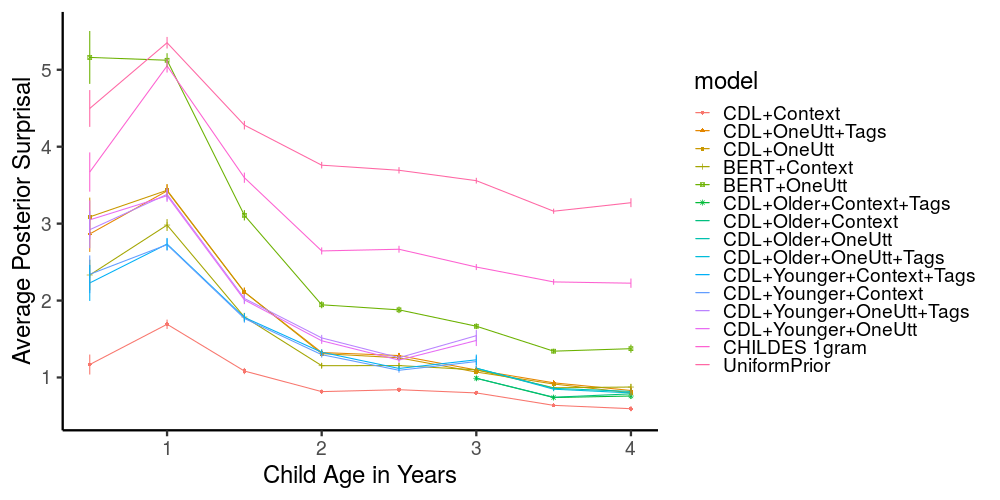

In [147]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [148]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,BERT+Context,5.348551,0.201515
2,0.5,BERT+OneUtt,9.231796,0.396100
3,0.5,CDL+Context,1.997437,0.171230
4,0.5,CDL+OneUtt,4.846468,0.250880
5,0.5,CDL+OneUtt+Tags,4.446737,0.227100
...,...,...,...,...
88,4.0,CDL+Older+OneUtt+Tags,4.218791,0.095647
89,4.0,CDL+OneUtt,4.366451,0.098279
90,4.0,CDL+OneUtt+Tags,4.376923,0.097620
91,4.0,CHILDES 1gram,8.351206,0.069989


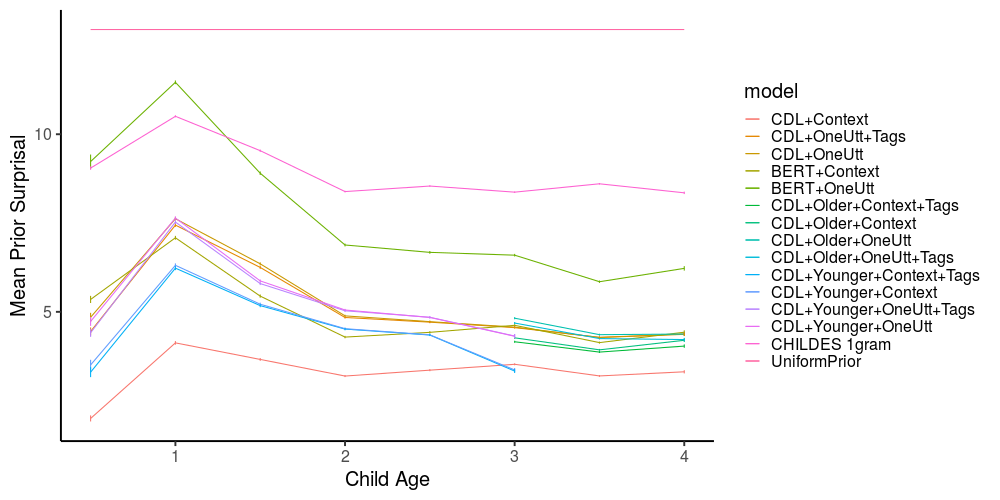

In [149]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [150]:
scores_across_time_short.set.value_counts()

success    166834
failure     61820
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [151]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,BERT+Context,failure,3.140217,0.082138
2,0.5,BERT+Context,success,1.321636,0.099834
3,0.5,BERT+OneUtt,failure,3.422165,0.078621
4,0.5,BERT+OneUtt,success,1.768993,0.111791
5,0.5,CDL+Context,failure,2.774801,0.090052
...,...,...,...,...,...
180,4.0,CDL+OneUtt+Tags,success,0.837273,0.033162
181,4.0,CHILDES 1gram,failure,2.840448,0.224749
182,4.0,CHILDES 1gram,success,2.070309,0.036971
183,4.0,UniformPrior,failure,5.122522,0.232140


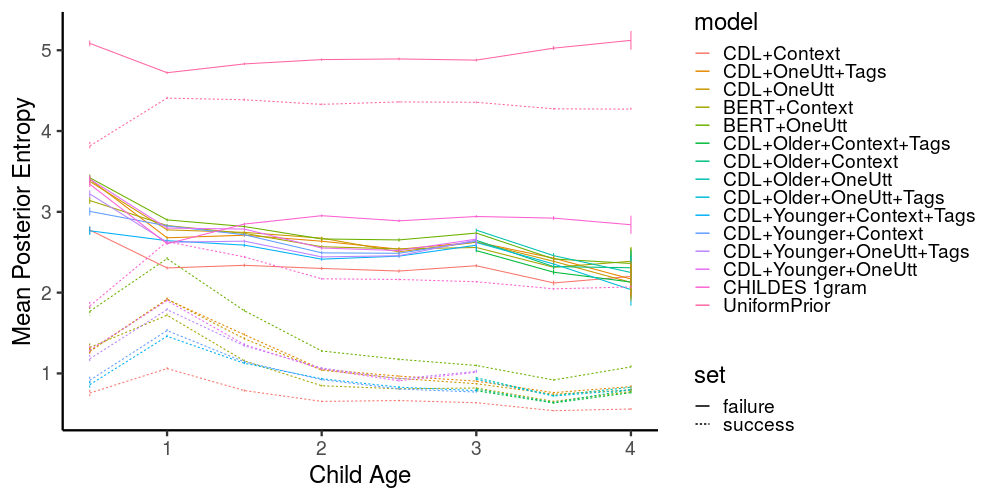

In [152]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [153]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [154]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age               model     gain  gain_sem comparison age_in_months
1 0.5        BERT+Context 18.40140 0.3306857  posterior             6
2 0.5         BERT+OneUtt 19.45872 0.6200643  posterior             6
3 0.5         CDL+Context 25.14147 0.5313961  posterior             6
4 0.5          CDL+OneUtt 23.82602 0.7229672  posterior             6
5 0.5     CDL+OneUtt+Tags 24.31830 0.6843232  posterior             6
6 0.5 CDL+Younger+Context 25.45295 0.5906969  posterior             6


In [155]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

   age        model     gain   gain_sem comparison age_in_months
11 0.5 UniformPrior 9.104747 0.09739289  posterior             6
22 1.5 UniformPrior 8.730274 0.04224507  posterior            18
33 1.0 UniformPrior 8.478009 0.04514851  posterior            12
44 2.5 UniformPrior 8.897544 0.03091987  posterior            30
55 2.0 UniformPrior 8.918204 0.03177128  posterior            24
66 3.5 UniformPrior 9.014511 0.02860235  posterior            42
81 3.0 UniformPrior 8.984787 0.03107766  posterior            36
92 4.0 UniformPrior 9.124695 0.05074393  posterior            48


In [156]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [157]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

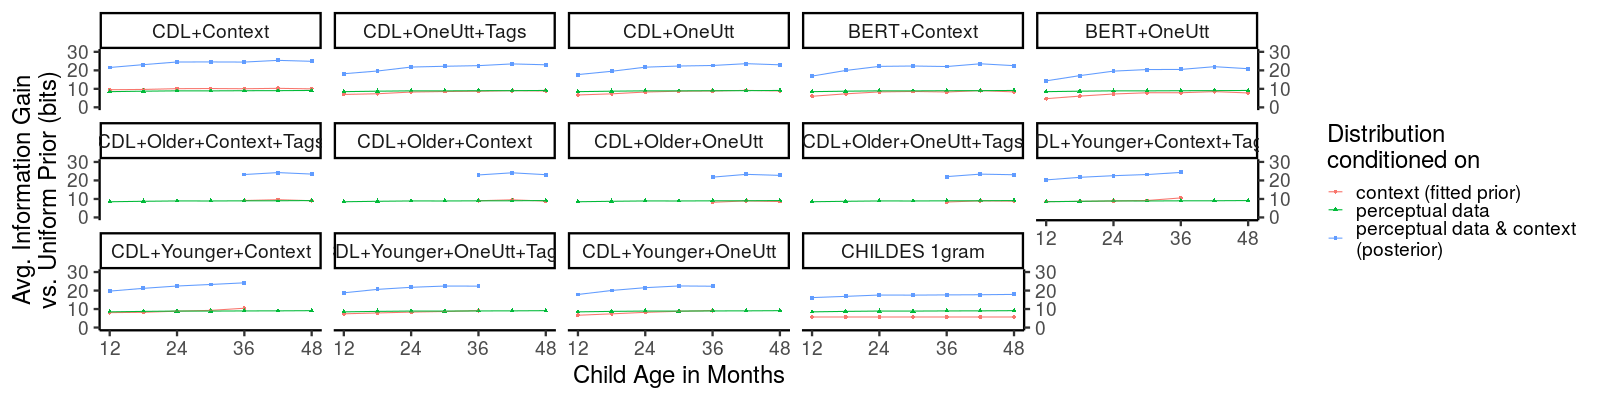

In [158]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

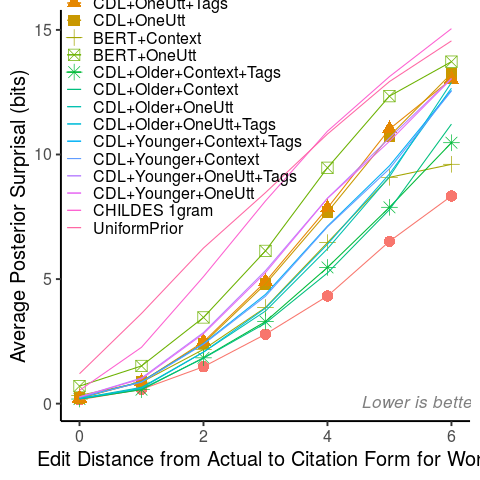

In [159]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [160]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance                    model mean_posterior_surprisal
1              0             BERT+Context                0.3275929
2              0      CDL+Younger+Context                0.2494291
3              0 CDL+Younger+Context+Tags                0.2458304
4              0       CDL+Younger+OneUtt                0.2720452
5              0  CDL+Younger+OneUtt+Tags                0.2680123
6              0            CHILDES 1gram                0.5345955
7              0              BERT+OneUtt                0.7038308
8              0              CDL+Context                0.1581777
9              0        CDL+Older+Context                0.1980611
10             0   CDL+Older+Context+Tags                0.1852059
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                   0.011940114 0.3275929 0.3275929           1.200931
2                   0.013549019 0.2494291 0.2494291           1.200931
3                   0.013427785 0.2458304 0.245830

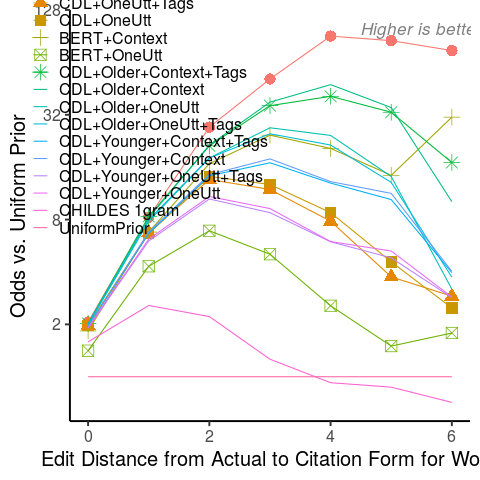

In [161]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

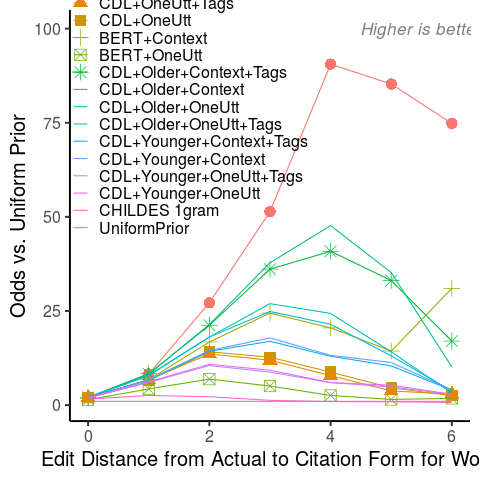

In [162]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [163]:
%%R
library(plotROC)

In [164]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 166834  61820


In [165]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+OneUtt"              
 [5] "CDL+Context"              "CDL+Younger+OneUtt+Tags" 
 [7] "CDL+Younger+Context+Tags" "CDL+Younger+OneUtt"      
 [9] "CDL+Younger+Context"      "CDL+Older+OneUtt+Tags"   
[11] "CDL+Older+Context+Tags"   "CDL+Older+OneUtt"        
[13] "CDL+Older+Context"        "UniformPrior"            
[15] "CHILDES 1gram"           


In [166]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case =

In [167]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [168]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [3] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [5] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [7] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"
 [9] "BERT+Context (AUC = 0.85)" "BERT+Context (AUC = 0.85)"


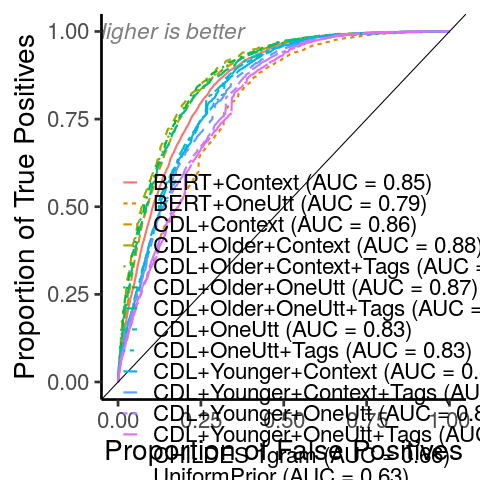

In [175]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    